In [81]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

## Creating Necessary Functions

In [82]:
def preprocess(df):
    """
    Preprocess the data removing uncessary data and setting elements to their correct types
    Handle Null values by backward fill null values
    Creating Features for our model training
    """
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)#remove empty column
    if df.index.name != 'Date':    
        df['Date'] = pd.to_datetime(df['Date']) #update column from string to datetime
        df.set_index('Date', inplace=True) 
        df = df.sort_index()
    df.fillna(method='bfill', inplace=True)
    return df

In [83]:
def feature_engineering(df):
    """
    Creating new features and concatentating other features
    Also using MinMaxScaler to Normalize the features between 0 and 1 to ensure large values are not weighted higher. 
    """
    df['Month'] = df.index.month #create a month feature to account for seasonality
    df['Week'] = df.index.isocalendar().week #create a week feature to account for seasonality
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter 

    features_to_scale = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
    scaler = MinMaxScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    df['Size_Type'] = df['Size'] * df['Type'] #concatenating the 2 highly correlated features in to one.

    return df

In [84]:
def add_lags(df):
    target_map = df['Weekly_Sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta(weeks=1)).map(target_map) #1 week back
    df['lag2'] = (df.index - pd.Timedelta(weeks=5)).map(target_map) #5 weeks back (1 month Approx)
    df['lag3'] = (df.index - pd.Timedelta(weeks=52)).map(target_map) #1 year back
    return df

In [85]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)

C:\Users\nmarr\AppData\Local\Temp\ipykernel_28232\3351921570.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


## Training With Cross-Validation

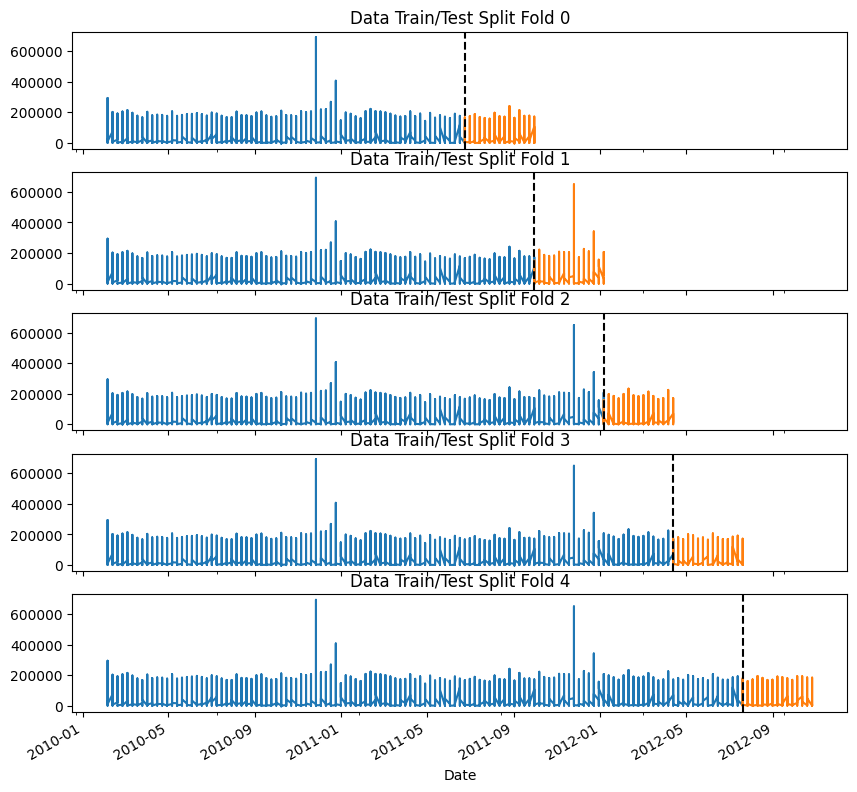

In [86]:
tss = TimeSeriesSplit(n_splits=5, test_size=42000)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Weekly_Sales'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['Weekly_Sales'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [87]:
df = feature_engineering(df)
df = add_lags(df)
features = ['Store', 'Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

tss = TimeSeriesSplit(n_splits=5, test_size=42000)
fold = 0
preds, scores = [], {'MAE': [], 'MSE': [], 'RMSE': []}
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, max_depth=3,
                            early_stopping_rounds=100, objective='reg:squarederror', learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['MSE'].append(mean_squared_error(y_test, y_pred))
    scores['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

[0]	validation_0-rmse:27475.38128	validation_1-rmse:26708.50892
[100]	validation_0-rmse:19119.26391	validation_1-rmse:17849.26527
[200]	validation_0-rmse:16233.89866	validation_1-rmse:14866.94975
[300]	validation_0-rmse:15096.60817	validation_1-rmse:13704.53231
[400]	validation_0-rmse:14230.50071	validation_1-rmse:12843.60191
[500]	validation_0-rmse:13558.58883	validation_1-rmse:12208.13923
[600]	validation_0-rmse:13090.25601	validation_1-rmse:11757.09921
[700]	validation_0-rmse:12702.16960	validation_1-rmse:11379.75801
[800]	validation_0-rmse:12382.67147	validation_1-rmse:11062.15774
[900]	validation_0-rmse:12099.89184	validation_1-rmse:10776.39341
[999]	validation_0-rmse:11860.75423	validation_1-rmse:10532.21960
[0]	validation_0-rmse:27349.61496	validation_1-rmse:31000.83759
[100]	validation_0-rmse:18936.22330	validation_1-rmse:23104.60219
[200]	validation_0-rmse:16030.54903	validation_1-rmse:20118.14930
[300]	validation_0-rmse:14893.44292	validation_1-rmse:18893.60423
[400]	validati

In [88]:
mean_mae = np.mean(scores['MAE'])
mean_mse = np.mean(scores['MSE'])
mean_rmse = np.mean(scores['RMSE'])

print(f'Fold Scores - Mean Absolute Error: {scores["MAE"]}')
print(f'Fold Scores - Mean Squared Error: {scores["MSE"]}')
print(f'Fold Scores - Root Mean Absolute Error: {scores["RMSE"]}')
print(f'Mean Absolute Error: {mean_mae}')
print(f'Mean Squared Error: {mean_mse}')
print(f'Root Mean Absolute Error: {mean_rmse}')



Fold Scores - Mean Absolute Error: [6701.10098403286, 8388.019659454578, 7042.4997428517145, 7188.679408837186, 6837.976861338938]
Fold Scores - Mean Squared Error: [110927649.94834435, 246791796.40470642, 125809995.6942032, 122456194.7519182, 111211127.85474862]
Fold Scores - Root Mean Absolute Error: [10532.219611665167, 15709.60841029166, 11216.505502793781, 11065.9927142538, 10545.668677459416]
Mean Absolute Error: 7231.6553313030545
Mean Squared Error: 143439352.93078417
Root Mean Absolute Error: 11813.998983292764


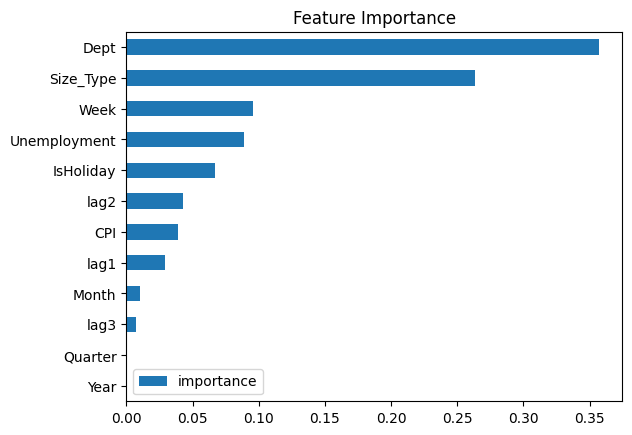

In [89]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

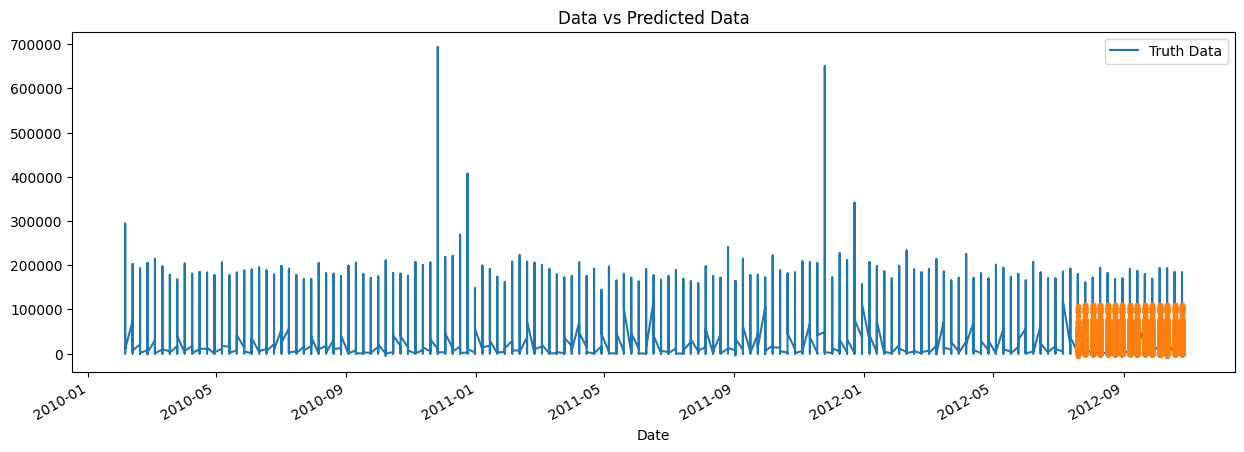

In [90]:
prediction = reg.predict(X_test)
prediction_series = pd.Series(prediction, index=X_test.index)
ax = df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data')
prediction_series.plot(ax=ax, style='.')
plt.legend()
plt.title('Data vs Predicted Data')
plt.show()

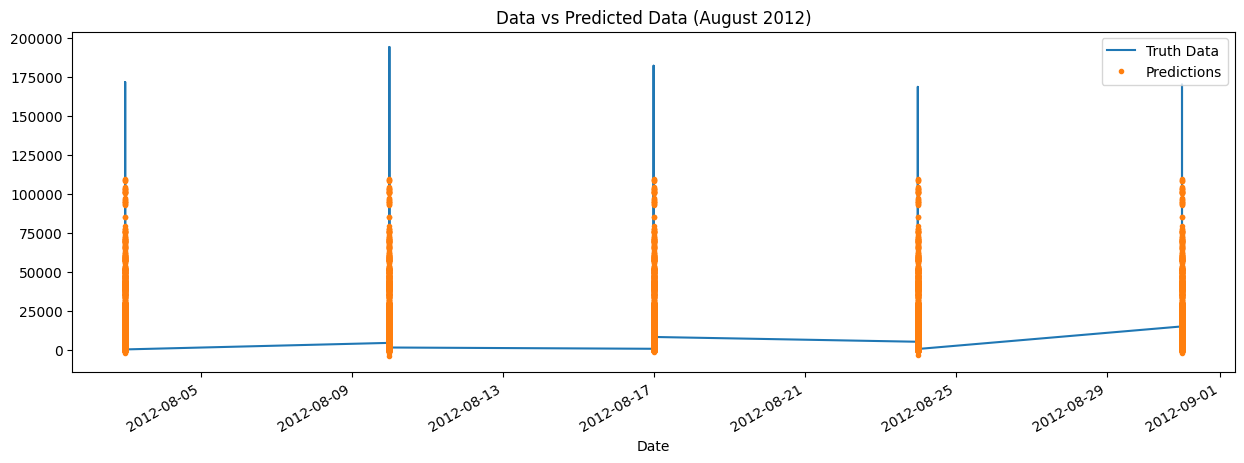

In [91]:
# Filter data from 2012-07 onwards
start_date = '2012-08-01'
end_date = '2012-09-01'
filtered_df = df.loc[start_date:end_date]
filtered_prediction_series = prediction_series.loc[start_date:end_date]

ax = filtered_df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data')
filtered_prediction_series.plot(ax=ax, style='.', label='Predictions')

plt.legend()
plt.title('Data vs Predicted Data (August 2012)')
plt.show()

## Predicting On Future Data

In [92]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)
df = feature_engineering(df)
df = add_lags(df)

features = ['Store', 'Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:squarederror', learning_rate=0.01)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=200)

C:\Users\nmarr\AppData\Local\Temp\ipykernel_28232\3351921570.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


[0]	validation_0-rmse:27548.62743
[200]	validation_0-rmse:11665.52807
[400]	validation_0-rmse:9354.83713
[499]	validation_0-rmse:8751.36666


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
df.index.max()

Timestamp('2012-10-26 00:00:00')

In [94]:
future = pd.date_range('2012-10-26', '2013-02-26', freq='1W')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = feature_engineering(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Month,Week,Year,Quarter,Size_Type,lag1,lag2,lag3,isFuture
2010-02-05,1.0,0.0,1.0,24924.50,0.434149,0.050100,0.0,0.002536,0.000205,0.0,...,0.630267,2,5,2010,1,1.890802,NaN,NaN,NaN,False
2010-02-05,35.0,0.0,83.0,5015.30,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False
2010-02-05,35.0,0.0,95.0,62831.98,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False
2010-02-05,35.0,0.0,26.0,10870.40,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False
2010-02-05,35.0,0.0,56.0,345.00,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False


In [101]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['Size_Type'] = 2.783704
future_w_features['Dept'] = 44
future_w_features['IsHoliday'] = df.loc['2011-10-26':'2012-02-26', 'IsHoliday'].mean()
future_w_features['CPI'] = df.loc['2011-10-26':'2012-02-26', 'CPI'].mean()
future_w_features['Unemployment'] = df.loc['2011-10-26':'2012-02-26', 'Unemployment'].mean()
future_w_features.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Month,Week,Year,Quarter,Size_Type,lag1,lag2,lag3,isFuture
2012-10-28,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10,43,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-04,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,44,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-11,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,45,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-18,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,46,2012,4,2.783704,NaN,NaN,NaN,True
2012-11-25,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,47,2012,4,2.783704,NaN,NaN,NaN,True


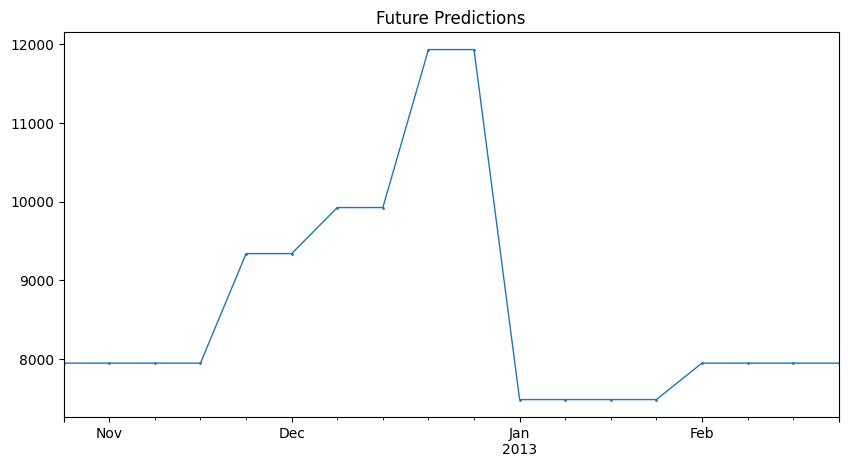

In [102]:
future_w_features['pred'] = reg.predict(future_w_features[features])
future_w_features['pred'].plot(figsize=(10,5), ms=1, lw=1, title='Future Predictions', marker='o', linestyle='-')
plt.show()

In [97]:
df.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Month,Week,Year,Quarter,Size_Type,lag1,lag2,lag3,isFuture
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,1.0,24924.50,0.434149,0.050100,0.0,0.002536,0.000205,0.0,...,0.630267,2,5,2010,1,1.890802,NaN,NaN,NaN,False
2010-02-05,35,0,83.0,5015.30,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False
2010-02-05,35,0,95.0,62831.98,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False
2010-02-05,35,0,26.0,10870.40,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False
2010-02-05,35,0,56.0,345.00,0.286204,0.156313,0.0,0.002536,0.000205,0.0,...,0.372434,2,5,2010,1,0.744867,NaN,NaN,NaN,False


            Store  IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  \
Date                                                                        
2010-10-29     28          0  44.0       5182.84     0.617906    0.272545   
2010-11-05     28          0  44.0       4772.54     0.660959    0.329158   
2010-11-12     28          0  44.0       4944.65     0.585616    0.329659   
2010-11-19     28          0  44.0       3583.53     0.589432    0.345190   
2010-11-26     28          1  44.0       6643.84     0.486497    0.345691   
2010-12-03     28          0  44.0       5462.05     0.444129    0.285070   
2010-12-10     28          0  44.0       5484.73     0.509491    0.366232   
2010-12-17     28          0  44.0       6639.71     0.536497    0.382766   
2010-12-24     28          0  44.0      10179.60     0.529159    0.382766   
2010-12-31     28          1  44.0       3347.35     0.466732    0.338677   
2011-01-07     28          0  44.0       3838.16     0.388454    0.408317   

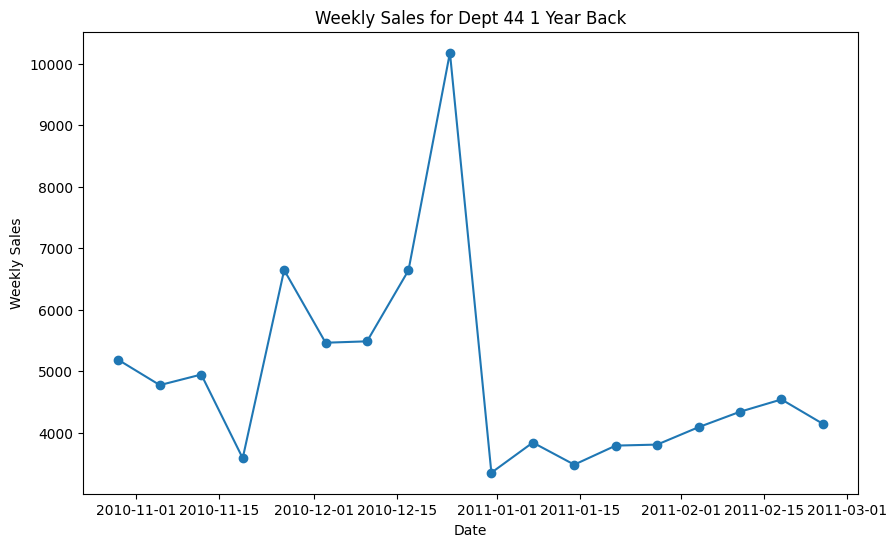

In [100]:
# Applying the mask
mask = (df.index >= '2010-10-26') & (df.index <= '2011-02-26') & (df['Dept']==44) & (df['Store']==28)
selected_data = df.loc[mask]
print(selected_data)

plt.figure(figsize=(10, 6))
plt.plot(selected_data.index, selected_data['Weekly_Sales'], marker='o', linestyle='-')
plt.title('Weekly Sales for Dept 44 1 Year Back')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()